# Hadamard tests to evaluate the complex partition function

In [1]:
from matplotlib import pyplot as plt

from qiskit import Aer, ClassicalRegister, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error

from knots_circuits import get_target_value, make_qiskit_hadamard_test_circuit, multiply_cx

Set the knot we are interested in, supported options:
- 'trefoil'
- 'trefoil-twist'
- 'arc-trefoil' (called "closed trefoil" in the manuscript)
- 'arc-trefoil-twist' (called "closed trefoil+twist" in the manuscript)

In [2]:
knot = 'trefoil'

This function returns the expected value of the complex partition functon

In [3]:
target_value = get_target_value(knot)
target_value

array([[0.+0.5j]])

## Hadamard test circuits

Get the Hadamard circuit for the 'real' or 'imag' part

In [4]:
part = 'imag'
circ = make_qiskit_hadamard_test_circuit(part, knot)

In [5]:
if part == 'real':
    target_value = target_value.real
elif part == 'imag':
    target_value = target_value.imag
else:
    raise ValueError('Please choose "real" or "imag" for part.')

In [6]:
# add a classical register to measure to
cbit = ClassicalRegister(1, 'meas')
circ.add_register(cbit)
circ.measure(-1, cbit)

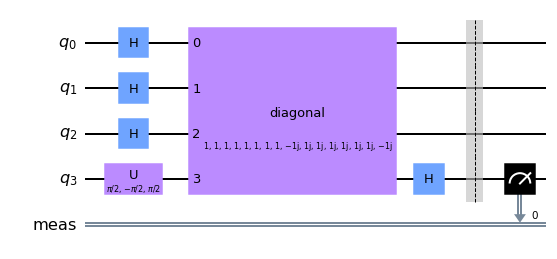

In [7]:
circ.draw(output='mpl')

Repeatedly calling `.decompose()` eventually exposes the circuit structure in primitive gates. (Note it may have some redundant gates such as pairs of CNOTs that cancel, these would be removed by a transpiler.)

In [8]:
circ_decomposed = circ.copy()
for _ in range(20):
    circ_decomposed = circ_decomposed.decompose()

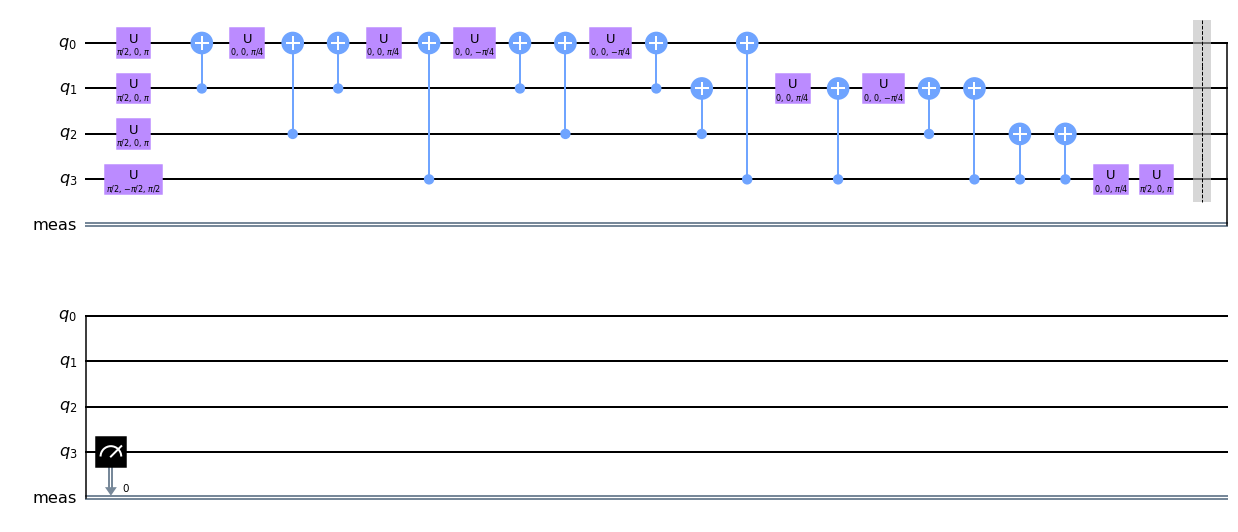

In [9]:
circ_decomposed.draw(output='mpl')

This circuit can be transpiled and executed on IBM Quantum hardware.

## Example: zero-noise extrapolation noisy simulation

Multiply the number of CNOT gates to generate the ZNE copies.

In [10]:
circ1 = circ_decomposed.copy()
circ3 = multiply_cx(circ_decomposed, 3)
circ5 = multiply_cx(circ_decomposed, 5)
circ7 = multiply_cx(circ_decomposed, 7)

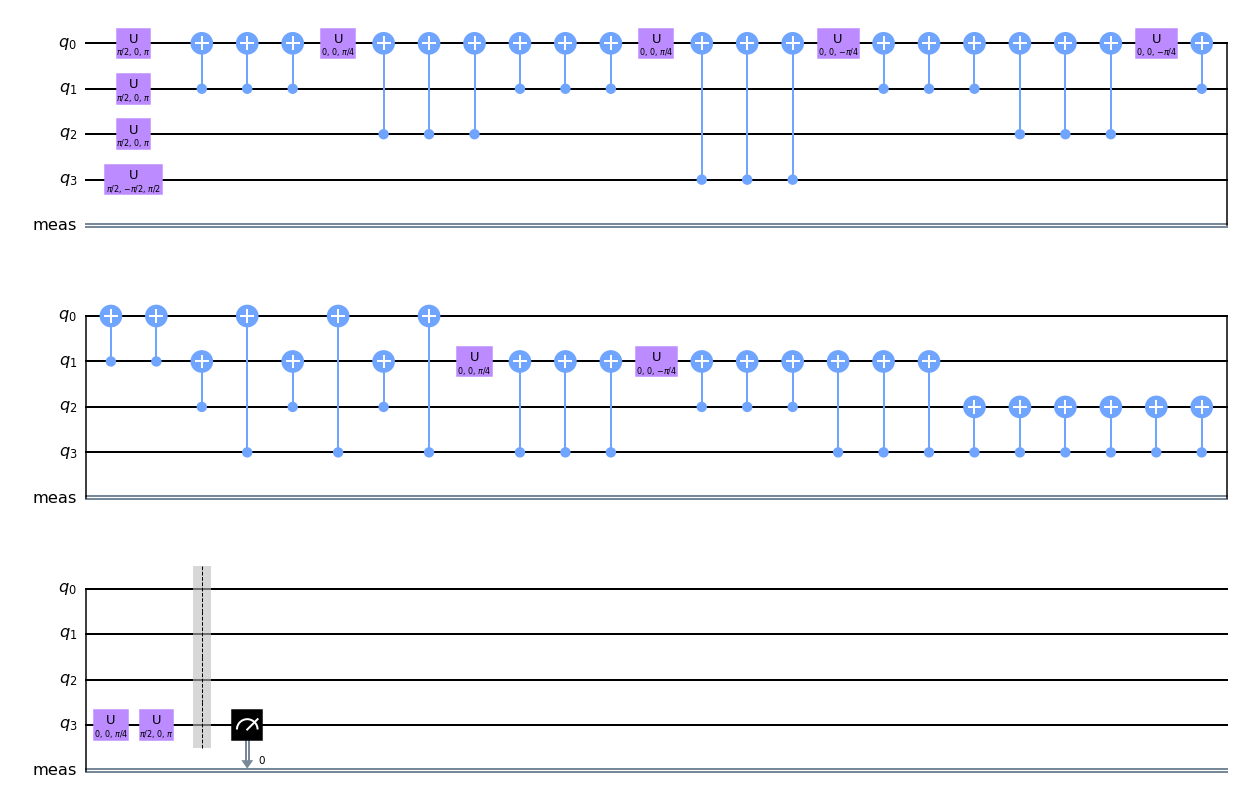

In [11]:
circ3.draw(output='mpl')

Make a noisy qasm simulator

In [12]:
n_shots = 8192
backend = Aer.get_backend('qasm_simulator')

In [19]:
# we add noise to CNOTs and measurements
cnot_depol_rate = 0.06
meas_bitflip_rate = 0.003

noise_model = NoiseModel()

error = depolarizing_error(cnot_depol_rate, 2)
noise_model.add_all_qubit_quantum_error(error, ['cx'])

error = pauli_error([('X', meas_bitflip_rate), ('I', 1-meas_bitflip_rate)])
noise_model.add_all_qubit_quantum_error(error, ['measure'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure', 'cx']
  All-qubits errors: ['cx', 'measure']


Execute the simulations on the noisy simulator to extract the estimates of \<Z\> on the control qubit

In [20]:
Z_estimates = []
for exe_circ in [
    circ1,
    circ3,
    circ5,
    circ7,
]:
    result = execute(
        exe_circ,
        backend=backend,
        optimization_level=0,
        shots=n_shots,
        noise_model=noise_model,
    ).result()
    
    Z_estimates.append(
        (result.get_counts()['0'] - result.get_counts()['1']) / n_shots
    )
    
Z_estimates

[0.25830078125, 0.085205078125, 0.013671875, 0.028564453125]

we can plot the zero-noise extrapolation series. The target value is indicated with a horizontal red line

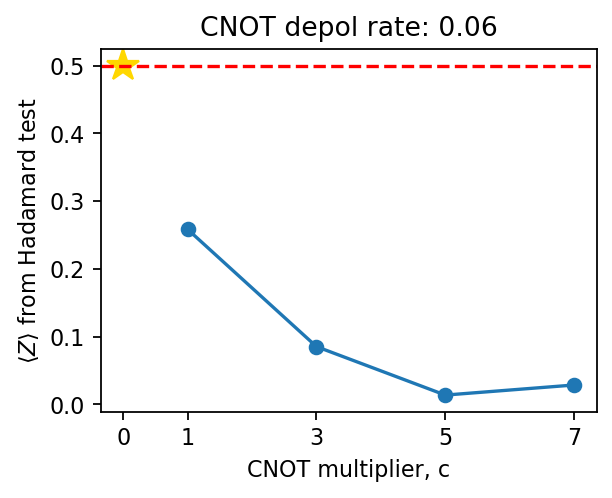

In [21]:
DPI = 160
fig, ax = plt.subplots(figsize=(4, 3), dpi=DPI)

ax.plot(
    range(1, 8, 2),
    Z_estimates,
    'o-'
)

ax.plot([0], target_value, '*', markersize=15, color='gold')

ax.set_title(f'CNOT depol rate: {cnot_depol_rate}')
ax.set_xlabel('CNOT multiplier, c')
ax.set_ylabel(r'$\langle Z \rangle$'+' from Hadamard test')
ax.axhline(y=target_value, linestyle='--', color='r')

ax.set_xticks([0, 1, 3, 5, 7])

plt.show()

It is interesting to repeat with different CNOT depolarising error rates

In [16]:
meas_bitflip_rate = 0.003

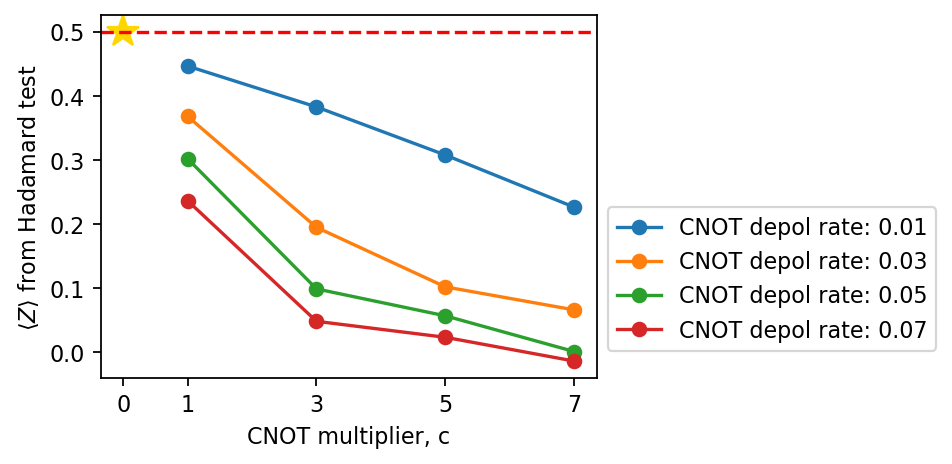

In [17]:
DPI = 160
fig, ax = plt.subplots(figsize=(4, 3), dpi=DPI)

for cnot_depol_rate in [0.01, 0.03, 0.05, 0.07]:

    noise_model = NoiseModel()
    error = depolarizing_error(cnot_depol_rate, 2)
    noise_model.add_all_qubit_quantum_error(error, ['cx'])
    error = pauli_error([('X', meas_bitflip_rate), ('I', 1-meas_bitflip_rate)])
    noise_model.add_all_qubit_quantum_error(error, ['measure'])

    Z_estimates = []
    for exe_circ in [
        circ1,
        circ3,
        circ5,
        circ7,
    ]:
        result = execute(
            exe_circ,
            backend=backend,
            optimization_level=0,
            shots=n_shots,
            noise_model=noise_model,
        ).result()
        Z_estimates.append(
            (result.get_counts()['0'] - result.get_counts()['1']) / n_shots
        )
        
    ax.plot(
        range(1, 8, 2),
        Z_estimates,
        'o-',
        label=f'CNOT depol rate: {cnot_depol_rate}'
    )

ax.plot([0], target_value, '*', markersize=15, color='gold')
    
plt.legend(bbox_to_anchor=(1, 0.5))
ax.set_xlabel('CNOT multiplier, c')
ax.set_ylabel(r'$\langle Z \rangle$'+' from Hadamard test')
ax.axhline(y=target_value, linestyle='--', color='r')

ax.set_xticks([0, 1, 3, 5, 7])

plt.show()